<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:25:16] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


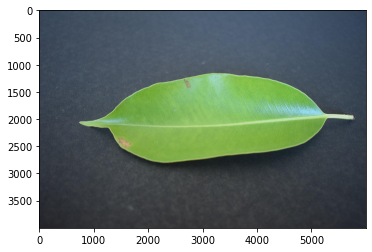

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

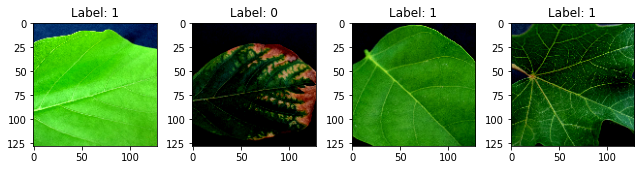

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:25:22] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:25:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2011864364549985 samples/sec                   batch loss = 0.4930562674999237 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2504874393481897 samples/sec                   batch loss = 0.8825502395629883 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.251100655370838 samples/sec                   batch loss = 1.6270567178726196 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2518559717842446 samples/sec                   batch loss = 0.5583644509315491 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2527944079358804 samples/sec                   batch loss = 1.1089482307434082 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2580388374092157 samples/sec                   batch loss = 0.6711809635162354 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.24936970084024 samples/sec                   batch loss = 0.5955109596252441 | accuracy = 0.5214285714285715


Epoch[1] Batch[40] Speed: 1.2481711221544063 samples/sec                   batch loss = 0.4587278366088867 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.250566761754334 samples/sec                   batch loss = 0.6177241206169128 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.2497644011759865 samples/sec                   batch loss = 0.5894319415092468 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2476143967062274 samples/sec                   batch loss = 0.2609582245349884 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.252642034950779 samples/sec                   batch loss = 0.5238813757896423 | accuracy = 0.5541666666666667


Epoch[1] Batch[65] Speed: 1.2467625426137683 samples/sec                   batch loss = 0.9714051485061646 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2500105985407617 samples/sec                   batch loss = 0.5971411466598511 | accuracy = 0.5642857142857143


Epoch[1] Batch[75] Speed: 1.2469944898671204 samples/sec                   batch loss = 0.4801890552043915 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2528144277679305 samples/sec                   batch loss = 0.6204057931900024 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.258030347407465 samples/sec                   batch loss = 1.0142985582351685 | accuracy = 0.5823529411764706


Epoch[1] Batch[90] Speed: 1.2487773274916385 samples/sec                   batch loss = 0.5592118501663208 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2476557766715246 samples/sec                   batch loss = 0.4332251250743866 | accuracy = 0.5894736842105263


Epoch[1] Batch[100] Speed: 1.2496675876363084 samples/sec                   batch loss = 0.3432762026786804 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2585568498870898 samples/sec                   batch loss = 0.8997797966003418 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.253030757599216 samples/sec                   batch loss = 0.7116997838020325 | accuracy = 0.5909090909090909


Epoch[1] Batch[115] Speed: 1.2490997618573607 samples/sec                   batch loss = 0.3096459209918976 | accuracy = 0.5978260869565217


Epoch[1] Batch[120] Speed: 1.2485731493920085 samples/sec                   batch loss = 0.3904714584350586 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.2483936542207656 samples/sec                   batch loss = 0.9352710247039795 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.2509167020393848 samples/sec                   batch loss = 0.5555006265640259 | accuracy = 0.6


Epoch[1] Batch[135] Speed: 1.2540898110196126 samples/sec                   batch loss = 0.43177852034568787 | accuracy = 0.6037037037037037


Epoch[1] Batch[140] Speed: 1.2512441616007606 samples/sec                   batch loss = 0.522649347782135 | accuracy = 0.6035714285714285


Epoch[1] Batch[145] Speed: 1.2509363820883308 samples/sec                   batch loss = 1.8036394119262695 | accuracy = 0.603448275862069


Epoch[1] Batch[150] Speed: 1.251089739794283 samples/sec                   batch loss = 0.7946070432662964 | accuracy = 0.6066666666666667


Epoch[1] Batch[155] Speed: 1.2523181433833188 samples/sec                   batch loss = 0.645012617111206 | accuracy = 0.6096774193548387


Epoch[1] Batch[160] Speed: 1.256515398200608 samples/sec                   batch loss = 0.7889711856842041 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2526780436373144 samples/sec                   batch loss = 1.1426242589950562 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.24910059884136 samples/sec                   batch loss = 0.6830142140388489 | accuracy = 0.6044117647058823


Epoch[1] Batch[175] Speed: 1.252842306917696 samples/sec                   batch loss = 0.7604944705963135 | accuracy = 0.6057142857142858


Epoch[1] Batch[180] Speed: 1.2539534302475803 samples/sec                   batch loss = 0.6841880679130554 | accuracy = 0.6069444444444444


Epoch[1] Batch[185] Speed: 1.252294493893902 samples/sec                   batch loss = 0.36726903915405273 | accuracy = 0.6108108108108108


Epoch[1] Batch[190] Speed: 1.248949123007361 samples/sec                   batch loss = 0.45820870995521545 | accuracy = 0.6144736842105263


Epoch[1] Batch[195] Speed: 1.2547076920959892 samples/sec                   batch loss = 1.0087803602218628 | accuracy = 0.6166666666666667


Epoch[1] Batch[200] Speed: 1.2600047119078412 samples/sec                   batch loss = 1.2111642360687256 | accuracy = 0.615


Epoch[1] Batch[205] Speed: 1.2544841229457873 samples/sec                   batch loss = 0.5018364787101746 | accuracy = 0.6170731707317073


Epoch[1] Batch[210] Speed: 1.255503072938349 samples/sec                   batch loss = 0.38298964500427246 | accuracy = 0.6202380952380953


Epoch[1] Batch[215] Speed: 1.2547589281413891 samples/sec                   batch loss = 0.6639332175254822 | accuracy = 0.622093023255814


Epoch[1] Batch[220] Speed: 1.2558890609930387 samples/sec                   batch loss = 0.9245362281799316 | accuracy = 0.6204545454545455


Epoch[1] Batch[225] Speed: 1.2518517683922727 samples/sec                   batch loss = 0.7439731359481812 | accuracy = 0.6155555555555555


Epoch[1] Batch[230] Speed: 1.2576421937459175 samples/sec                   batch loss = 0.499022513628006 | accuracy = 0.6184782608695653


Epoch[1] Batch[235] Speed: 1.2588666909077484 samples/sec                   batch loss = 0.4705438017845154 | accuracy = 0.6191489361702127


Epoch[1] Batch[240] Speed: 1.2554964022338075 samples/sec                   batch loss = 0.6294618248939514 | accuracy = 0.621875


Epoch[1] Batch[245] Speed: 1.255757458176637 samples/sec                   batch loss = 0.6340909600257874 | accuracy = 0.6204081632653061


Epoch[1] Batch[250] Speed: 1.255850799330471 samples/sec                   batch loss = 0.3900204002857208 | accuracy = 0.624


Epoch[1] Batch[255] Speed: 1.2548930437544912 samples/sec                   batch loss = 0.49281758069992065 | accuracy = 0.6274509803921569


Epoch[1] Batch[260] Speed: 1.2555224277780817 samples/sec                   batch loss = 0.479658842086792 | accuracy = 0.625


Epoch[1] Batch[265] Speed: 1.2609573050779916 samples/sec                   batch loss = 0.4213826358318329 | accuracy = 0.6264150943396226


Epoch[1] Batch[270] Speed: 1.257895277461419 samples/sec                   batch loss = 1.5652509927749634 | accuracy = 0.6296296296296297


Epoch[1] Batch[275] Speed: 1.2514494009799029 samples/sec                   batch loss = 0.4800488352775574 | accuracy = 0.6327272727272727


Epoch[1] Batch[280] Speed: 1.2547666232934997 samples/sec                   batch loss = 0.5098937749862671 | accuracy = 0.6285714285714286


Epoch[1] Batch[285] Speed: 1.2591200787478396 samples/sec                   batch loss = 0.4131130278110504 | accuracy = 0.6333333333333333


Epoch[1] Batch[290] Speed: 1.249923151985927 samples/sec                   batch loss = 1.094348430633545 | accuracy = 0.6327586206896552


Epoch[1] Batch[295] Speed: 1.250601439339716 samples/sec                   batch loss = 0.3970918655395508 | accuracy = 0.6347457627118644


Epoch[1] Batch[300] Speed: 1.2438280913367454 samples/sec                   batch loss = 0.36227715015411377 | accuracy = 0.6341666666666667


Epoch[1] Batch[305] Speed: 1.2503615321989474 samples/sec                   batch loss = 0.32782304286956787 | accuracy = 0.6368852459016393


Epoch[1] Batch[310] Speed: 1.245560728600214 samples/sec                   batch loss = 0.39924687147140503 | accuracy = 0.6403225806451613


Epoch[1] Batch[315] Speed: 1.2490009126366488 samples/sec                   batch loss = 0.6241755485534668 | accuracy = 0.6412698412698413


Epoch[1] Batch[320] Speed: 1.2543658502265933 samples/sec                   batch loss = 0.4138951897621155 | accuracy = 0.64296875


Epoch[1] Batch[325] Speed: 1.253347620978574 samples/sec                   batch loss = 0.6668704748153687 | accuracy = 0.6430769230769231


Epoch[1] Batch[330] Speed: 1.2603176332145047 samples/sec                   batch loss = 0.7455223798751831 | accuracy = 0.6431818181818182


Epoch[1] Batch[335] Speed: 1.2543605983470496 samples/sec                   batch loss = 0.7225154638290405 | accuracy = 0.6455223880597015


Epoch[1] Batch[340] Speed: 1.2494857304489504 samples/sec                   batch loss = 0.6522761583328247 | accuracy = 0.6477941176470589


Epoch[1] Batch[345] Speed: 1.2517639706573054 samples/sec                   batch loss = 0.36860230565071106 | accuracy = 0.6507246376811594


Epoch[1] Batch[350] Speed: 1.2492020682117944 samples/sec                   batch loss = 0.6565242409706116 | accuracy = 0.6521428571428571


Epoch[1] Batch[355] Speed: 1.2560394979919498 samples/sec                   batch loss = 0.49045658111572266 | accuracy = 0.652112676056338


Epoch[1] Batch[360] Speed: 1.2581011952669847 samples/sec                   batch loss = 0.35559412837028503 | accuracy = 0.6548611111111111


Epoch[1] Batch[365] Speed: 1.252006378381799 samples/sec                   batch loss = 0.4505796730518341 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.2581233663429299 samples/sec                   batch loss = 0.16523998975753784 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.2513645530734863 samples/sec                   batch loss = 0.43418723344802856 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.2508523498044044 samples/sec                   batch loss = 0.756554126739502 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2509864710727736 samples/sec                   batch loss = 0.2935176193714142 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2509680953184108 samples/sec                   batch loss = 0.40664613246917725 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.241108273152156 samples/sec                   batch loss = 0.48872435092926025 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.2510322728913887 samples/sec                   batch loss = 0.6984941959381104 | accuracy = 0.659375


Epoch[1] Batch[405] Speed: 1.2444606378095757 samples/sec                   batch loss = 0.8939580917358398 | accuracy = 0.6598765432098765


Epoch[1] Batch[410] Speed: 1.2476248806082162 samples/sec                   batch loss = 0.6663316488265991 | accuracy = 0.6603658536585366


Epoch[1] Batch[415] Speed: 1.2466261760485156 samples/sec                   batch loss = 0.34241175651550293 | accuracy = 0.6602409638554216


Epoch[1] Batch[420] Speed: 1.2441933693512184 samples/sec                   batch loss = 0.5698636174201965 | accuracy = 0.6589285714285714


Epoch[1] Batch[425] Speed: 1.2436689488838406 samples/sec                   batch loss = 0.7962487936019897 | accuracy = 0.6576470588235294


Epoch[1] Batch[430] Speed: 1.2470251693370293 samples/sec                   batch loss = 0.3612939417362213 | accuracy = 0.6575581395348837


Epoch[1] Batch[435] Speed: 1.2458824290362243 samples/sec                   batch loss = 0.3952028751373291 | accuracy = 0.656896551724138


Epoch[1] Batch[440] Speed: 1.2461658813578005 samples/sec                   batch loss = 0.3335736393928528 | accuracy = 0.6585227272727273


Epoch[1] Batch[445] Speed: 1.2430532319560665 samples/sec                   batch loss = 0.6285409927368164 | accuracy = 0.6578651685393259


Epoch[1] Batch[450] Speed: 1.241472506403561 samples/sec                   batch loss = 0.39357396960258484 | accuracy = 0.66


Epoch[1] Batch[455] Speed: 1.248864706750214 samples/sec                   batch loss = 0.628127932548523 | accuracy = 0.6604395604395604


Epoch[1] Batch[460] Speed: 1.242412086424914 samples/sec                   batch loss = 0.6714986562728882 | accuracy = 0.6614130434782609


Epoch[1] Batch[465] Speed: 1.242200878851175 samples/sec                   batch loss = 0.4641920328140259 | accuracy = 0.6629032258064517


Epoch[1] Batch[470] Speed: 1.2384462140218917 samples/sec                   batch loss = 0.8394970297813416 | accuracy = 0.6632978723404256


Epoch[1] Batch[475] Speed: 1.2428127133429416 samples/sec                   batch loss = 0.5145357847213745 | accuracy = 0.6642105263157895


Epoch[1] Batch[480] Speed: 1.239858777491484 samples/sec                   batch loss = 0.5369884967803955 | accuracy = 0.6640625


Epoch[1] Batch[485] Speed: 1.2459931849647388 samples/sec                   batch loss = 0.39713361859321594 | accuracy = 0.6649484536082474


Epoch[1] Batch[490] Speed: 1.2394193974432253 samples/sec                   batch loss = 0.6865417957305908 | accuracy = 0.6653061224489796


Epoch[1] Batch[495] Speed: 1.2395269924824028 samples/sec                   batch loss = 0.6335782408714294 | accuracy = 0.6646464646464646


Epoch[1] Batch[500] Speed: 1.2380616441530328 samples/sec                   batch loss = 0.8993203639984131 | accuracy = 0.6645


Epoch[1] Batch[505] Speed: 1.2519172511035936 samples/sec                   batch loss = 1.312151312828064 | accuracy = 0.6653465346534654


Epoch[1] Batch[510] Speed: 1.2470975640395718 samples/sec                   batch loss = 0.3222641348838806 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.2489480072995929 samples/sec                   batch loss = 0.5322285890579224 | accuracy = 0.6655339805825242


Epoch[1] Batch[520] Speed: 1.2443192370152505 samples/sec                   batch loss = 0.3854585587978363 | accuracy = 0.6649038461538461


Epoch[1] Batch[525] Speed: 1.2417926497213534 samples/sec                   batch loss = 0.4772736430168152 | accuracy = 0.6642857142857143


Epoch[1] Batch[530] Speed: 1.2409185267630958 samples/sec                   batch loss = 0.6914078593254089 | accuracy = 0.6641509433962264


Epoch[1] Batch[535] Speed: 1.2437755310979912 samples/sec                   batch loss = 0.42783454060554504 | accuracy = 0.6644859813084112


Epoch[1] Batch[540] Speed: 1.2430857441010128 samples/sec                   batch loss = 0.9187604784965515 | accuracy = 0.6648148148148149


Epoch[1] Batch[545] Speed: 1.2445172255894135 samples/sec                   batch loss = 0.19847282767295837 | accuracy = 0.6655963302752294


Epoch[1] Batch[550] Speed: 1.242102198885713 samples/sec                   batch loss = 0.5196168422698975 | accuracy = 0.6645454545454546


Epoch[1] Batch[555] Speed: 1.2380568019966278 samples/sec                   batch loss = 0.5929667949676514 | accuracy = 0.6653153153153153


Epoch[1] Batch[560] Speed: 1.2460131730943047 samples/sec                   batch loss = 0.378140926361084 | accuracy = 0.6674107142857143


Epoch[1] Batch[565] Speed: 1.2421386157614307 samples/sec                   batch loss = 0.5935805439949036 | accuracy = 0.668141592920354


Epoch[1] Batch[570] Speed: 1.2424555143038285 samples/sec                   batch loss = 0.20827063918113708 | accuracy = 0.668859649122807


Epoch[1] Batch[575] Speed: 1.2429517460591224 samples/sec                   batch loss = 0.2834101617336273 | accuracy = 0.668695652173913


Epoch[1] Batch[580] Speed: 1.2399077083619712 samples/sec                   batch loss = 0.2517179846763611 | accuracy = 0.6698275862068965


Epoch[1] Batch[585] Speed: 1.2450635206502596 samples/sec                   batch loss = 0.2998450696468353 | accuracy = 0.6705128205128205


Epoch[1] Batch[590] Speed: 1.2414740681257617 samples/sec                   batch loss = 0.6980030536651611 | accuracy = 0.6699152542372881


Epoch[1] Batch[595] Speed: 1.2489424287906519 samples/sec                   batch loss = 0.41460636258125305 | accuracy = 0.6718487394957983


Epoch[1] Batch[600] Speed: 1.2472379280341754 samples/sec                   batch loss = 0.5067601799964905 | accuracy = 0.6720833333333334


Epoch[1] Batch[605] Speed: 1.245272467853019 samples/sec                   batch loss = 0.7148528099060059 | accuracy = 0.6710743801652893


Epoch[1] Batch[610] Speed: 1.2423953417402211 samples/sec                   batch loss = 0.18454915285110474 | accuracy = 0.6721311475409836


Epoch[1] Batch[615] Speed: 1.242820262665277 samples/sec                   batch loss = 0.5515727400779724 | accuracy = 0.6731707317073171


Epoch[1] Batch[620] Speed: 1.2462207729262265 samples/sec                   batch loss = 0.4098963439464569 | accuracy = 0.6733870967741935


Epoch[1] Batch[625] Speed: 1.242369397570787 samples/sec                   batch loss = 0.611398458480835 | accuracy = 0.6736


Epoch[1] Batch[630] Speed: 1.2459912417085686 samples/sec                   batch loss = 0.3806058466434479 | accuracy = 0.6742063492063493


Epoch[1] Batch[635] Speed: 1.2404455609485527 samples/sec                   batch loss = 0.358945369720459 | accuracy = 0.675984251968504


Epoch[1] Batch[640] Speed: 1.2500757024832798 samples/sec                   batch loss = 0.39123040437698364 | accuracy = 0.67578125


Epoch[1] Batch[645] Speed: 1.2457105511446438 samples/sec                   batch loss = 0.5775738954544067 | accuracy = 0.6755813953488372


Epoch[1] Batch[650] Speed: 1.2521011250629699 samples/sec                   batch loss = 0.735812783241272 | accuracy = 0.6734615384615384


Epoch[1] Batch[655] Speed: 1.2472067745122002 samples/sec                   batch loss = 0.1572490781545639 | accuracy = 0.6751908396946565


Epoch[1] Batch[660] Speed: 1.2460287198606712 samples/sec                   batch loss = 0.28921470046043396 | accuracy = 0.6757575757575758


Epoch[1] Batch[665] Speed: 1.246831756352131 samples/sec                   batch loss = 0.1507939249277115 | accuracy = 0.6766917293233082


Epoch[1] Batch[670] Speed: 1.2425381460668956 samples/sec                   batch loss = 0.7215612530708313 | accuracy = 0.6764925373134328


Epoch[1] Batch[675] Speed: 1.2454102024929115 samples/sec                   batch loss = 0.7092824578285217 | accuracy = 0.6766666666666666


Epoch[1] Batch[680] Speed: 1.2477880068418095 samples/sec                   batch loss = 0.17587968707084656 | accuracy = 0.6779411764705883


Epoch[1] Batch[685] Speed: 1.2454322983345407 samples/sec                   batch loss = 0.12966077029705048 | accuracy = 0.6791970802919708


Epoch[1] Batch[690] Speed: 1.2464437212682522 samples/sec                   batch loss = 0.7383190393447876 | accuracy = 0.6807971014492754


Epoch[1] Batch[695] Speed: 1.2530014663595432 samples/sec                   batch loss = 0.8144738674163818 | accuracy = 0.6805755395683454


Epoch[1] Batch[700] Speed: 1.245133469954612 samples/sec                   batch loss = 0.6613502502441406 | accuracy = 0.6807142857142857


Epoch[1] Batch[705] Speed: 1.244677877995837 samples/sec                   batch loss = 0.4245930016040802 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.2462867788035474 samples/sec                   batch loss = 0.5765058398246765 | accuracy = 0.6823943661971831


Epoch[1] Batch[715] Speed: 1.243499247958355 samples/sec                   batch loss = 0.34961825609207153 | accuracy = 0.6828671328671329


Epoch[1] Batch[720] Speed: 1.2411685965676216 samples/sec                   batch loss = 0.7413961887359619 | accuracy = 0.6833333333333333


Epoch[1] Batch[725] Speed: 1.2420042701536602 samples/sec                   batch loss = 0.6555031538009644 | accuracy = 0.6841379310344827


Epoch[1] Batch[730] Speed: 1.2412399455273064 samples/sec                   batch loss = 0.27077171206474304 | accuracy = 0.6845890410958904


Epoch[1] Batch[735] Speed: 1.238508016056326 samples/sec                   batch loss = 0.6004801988601685 | accuracy = 0.6840136054421768


Epoch[1] Batch[740] Speed: 1.2415750372108798 samples/sec                   batch loss = 0.7845366597175598 | accuracy = 0.6841216216216216


Epoch[1] Batch[745] Speed: 1.2481643434161276 samples/sec                   batch loss = 0.9070279598236084 | accuracy = 0.684228187919463


Epoch[1] Batch[750] Speed: 1.2441531413628095 samples/sec                   batch loss = 0.2076934427022934 | accuracy = 0.6853333333333333


Epoch[1] Batch[755] Speed: 1.2453476172724975 samples/sec                   batch loss = 1.0207087993621826 | accuracy = 0.6850993377483444


Epoch[1] Batch[760] Speed: 1.242744773568847 samples/sec                   batch loss = 0.591958224773407 | accuracy = 0.6855263157894737


Epoch[1] Batch[765] Speed: 1.2464864127523496 samples/sec                   batch loss = 0.23436275124549866 | accuracy = 0.6862745098039216


Epoch[1] Batch[770] Speed: 1.2423555059254936 samples/sec                   batch loss = 0.3946871757507324 | accuracy = 0.687012987012987


Epoch[1] Batch[775] Speed: 1.243606815088121 samples/sec                   batch loss = 0.6227437853813171 | accuracy = 0.6874193548387096


Epoch[1] Batch[780] Speed: 1.245791026276667 samples/sec                   batch loss = 0.3765888810157776 | accuracy = 0.6881410256410256


Epoch[1] Batch[785] Speed: 1.2457210955700138 samples/sec                   batch loss = 0.27294543385505676 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.688769035532995
[Epoch 1] time cost: 657.757482290268
[Epoch 1] validation: validation accuracy=0.7188888888888889


Epoch[2] Batch[5] Speed: 1.2489487511045503 samples/sec                   batch loss = 0.42113298177719116 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2602707703124683 samples/sec                   batch loss = 0.3549087941646576 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2519623737056214 samples/sec                   batch loss = 0.3597370684146881 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2554114743894718 samples/sec                   batch loss = 0.3487582504749298 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2571108985773258 samples/sec                   batch loss = 0.3744644522666931 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.254420528656265 samples/sec                   batch loss = 0.5092126727104187 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2621737410906253 samples/sec                   batch loss = 0.9491013288497925 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2619328859221943 samples/sec                   batch loss = 0.5678452849388123 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2578488774422474 samples/sec                   batch loss = 0.7437832951545715 | accuracy = 0.7


Epoch[2] Batch[50] Speed: 1.2537507416889735 samples/sec                   batch loss = 0.5905510187149048 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2518848358382024 samples/sec                   batch loss = 0.2966116964817047 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2554456696175285 samples/sec                   batch loss = 1.0610889196395874 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2621960559382561 samples/sec                   batch loss = 0.6824657320976257 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2594870199510926 samples/sec                   batch loss = 0.4345749020576477 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2604932817632404 samples/sec                   batch loss = 0.26528772711753845 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.257481758991737 samples/sec                   batch loss = 0.3367995321750641 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2576306923603724 samples/sec                   batch loss = 0.7611769437789917 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.252594618877404 samples/sec                   batch loss = 0.8706191778182983 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2624152581653747 samples/sec                   batch loss = 0.22736908495426178 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2590765175008782 samples/sec                   batch loss = 0.29041755199432373 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.262994401702781 samples/sec                   batch loss = 0.13987630605697632 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2642131536757635 samples/sec                   batch loss = 1.0555938482284546 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2575421764411572 samples/sec                   batch loss = 0.5839568376541138 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2552976289792916 samples/sec                   batch loss = 0.4346908926963806 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.2602953847355758 samples/sec                   batch loss = 0.2347194254398346 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.255333790506291 samples/sec                   batch loss = 0.15585406124591827 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.261124031383596 samples/sec                   batch loss = 0.4036589562892914 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.2591309459060984 samples/sec                   batch loss = 0.6570689678192139 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.256240951954363 samples/sec                   batch loss = 0.24057503044605255 | accuracy = 0.7482758620689656


Epoch[2] Batch[150] Speed: 1.2570833000840318 samples/sec                   batch loss = 0.4737178087234497 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2574063631422567 samples/sec                   batch loss = 0.6959072947502136 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.2551702818526873 samples/sec                   batch loss = 0.42834168672561646 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.2594455132990765 samples/sec                   batch loss = 0.4778438210487366 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2607620098678889 samples/sec                   batch loss = 0.680009126663208 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.2522675738230855 samples/sec                   batch loss = 0.4059164822101593 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.255648718662792 samples/sec                   batch loss = 0.12672121822834015 | accuracy = 0.7527777777777778


Epoch[2] Batch[185] Speed: 1.2564231814244378 samples/sec                   batch loss = 0.10206697136163712 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2606308994335762 samples/sec                   batch loss = 0.8833091855049133 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2538068657092758 samples/sec                   batch loss = 0.34600695967674255 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.255608404302946 samples/sec                   batch loss = 0.19307099282741547 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.259055824602281 samples/sec                   batch loss = 1.3542028665542603 | accuracy = 0.7560975609756098


Epoch[2] Batch[210] Speed: 1.2589700366437584 samples/sec                   batch loss = 0.48011982440948486 | accuracy = 0.7571428571428571


Epoch[2] Batch[215] Speed: 1.258795567914174 samples/sec                   batch loss = 0.5152726173400879 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2534773143849034 samples/sec                   batch loss = 0.5323691368103027 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2542020310530055 samples/sec                   batch loss = 0.2981233298778534 | accuracy = 0.7644444444444445


Epoch[2] Batch[230] Speed: 1.2559760279882086 samples/sec                   batch loss = 0.1333906054496765 | accuracy = 0.7663043478260869


Epoch[2] Batch[235] Speed: 1.2583366259521969 samples/sec                   batch loss = 0.9654216766357422 | accuracy = 0.7659574468085106


Epoch[2] Batch[240] Speed: 1.2571465052496449 samples/sec                   batch loss = 0.37965771555900574 | accuracy = 0.765625


Epoch[2] Batch[245] Speed: 1.2547910231803894 samples/sec                   batch loss = 0.3370666205883026 | accuracy = 0.7663265306122449


Epoch[2] Batch[250] Speed: 1.259289911346441 samples/sec                   batch loss = 0.6562523245811462 | accuracy = 0.763


Epoch[2] Batch[255] Speed: 1.2550850225556305 samples/sec                   batch loss = 0.299568235874176 | accuracy = 0.7627450980392156


Epoch[2] Batch[260] Speed: 1.255810095993346 samples/sec                   batch loss = 0.5468688011169434 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.253428617684838 samples/sec                   batch loss = 0.6941100358963013 | accuracy = 0.7632075471698113


Epoch[2] Batch[270] Speed: 1.260522545496975 samples/sec                   batch loss = 0.33629584312438965 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.2716839715383554 samples/sec                   batch loss = 0.28709936141967773 | accuracy = 0.7618181818181818


Epoch[2] Batch[280] Speed: 1.2623179944021428 samples/sec                   batch loss = 0.3150595426559448 | accuracy = 0.7633928571428571


Epoch[2] Batch[285] Speed: 1.2687392039072156 samples/sec                   batch loss = 0.4507289528846741 | accuracy = 0.762280701754386


Epoch[2] Batch[290] Speed: 1.2634021354135485 samples/sec                   batch loss = 0.4306083917617798 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2721211606066218 samples/sec                   batch loss = 0.15038219094276428 | accuracy = 0.7610169491525424


Epoch[2] Batch[300] Speed: 1.2751476638770147 samples/sec                   batch loss = 0.5020879507064819 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2727443898351385 samples/sec                   batch loss = 0.3390139043331146 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2689419692482373 samples/sec                   batch loss = 0.17856436967849731 | accuracy = 0.7653225806451613


Epoch[2] Batch[315] Speed: 1.2765270268419506 samples/sec                   batch loss = 0.2686329483985901 | accuracy = 0.765079365079365


Epoch[2] Batch[320] Speed: 1.2666933989868245 samples/sec                   batch loss = 0.5302586555480957 | accuracy = 0.7640625


Epoch[2] Batch[325] Speed: 1.266599012915565 samples/sec                   batch loss = 0.41159120202064514 | accuracy = 0.7669230769230769


Epoch[2] Batch[330] Speed: 1.2690515835558387 samples/sec                   batch loss = 0.8606885671615601 | accuracy = 0.7659090909090909


Epoch[2] Batch[335] Speed: 1.2659852252061907 samples/sec                   batch loss = 0.4864272177219391 | accuracy = 0.767910447761194


Epoch[2] Batch[340] Speed: 1.26593096679149 samples/sec                   batch loss = 0.36509621143341064 | accuracy = 0.7661764705882353


Epoch[2] Batch[345] Speed: 1.269978975256659 samples/sec                   batch loss = 0.18744611740112305 | accuracy = 0.768840579710145


Epoch[2] Batch[350] Speed: 1.2640330384764533 samples/sec                   batch loss = 0.7152801752090454 | accuracy = 0.7685714285714286


Epoch[2] Batch[355] Speed: 1.2687748966548242 samples/sec                   batch loss = 0.8576309084892273 | accuracy = 0.7683098591549296


Epoch[2] Batch[360] Speed: 1.2653671648198517 samples/sec                   batch loss = 0.14213994145393372 | accuracy = 0.7701388888888889


Epoch[2] Batch[365] Speed: 1.268280078779461 samples/sec                   batch loss = 0.5643048882484436 | accuracy = 0.7719178082191781


Epoch[2] Batch[370] Speed: 1.2734761938087857 samples/sec                   batch loss = 0.2718694508075714 | accuracy = 0.7702702702702703


Epoch[2] Batch[375] Speed: 1.2626463196858604 samples/sec                   batch loss = 0.5339157581329346 | accuracy = 0.7706666666666667


Epoch[2] Batch[380] Speed: 1.2643304323514306 samples/sec                   batch loss = 0.29416030645370483 | accuracy = 0.7697368421052632


Epoch[2] Batch[385] Speed: 1.2687551310679699 samples/sec                   batch loss = 0.523583710193634 | accuracy = 0.7694805194805194


Epoch[2] Batch[390] Speed: 1.2671282155315275 samples/sec                   batch loss = 0.8082088232040405 | accuracy = 0.7685897435897436


Epoch[2] Batch[395] Speed: 1.2618216507967643 samples/sec                   batch loss = 0.06263213604688644 | accuracy = 0.769620253164557


Epoch[2] Batch[400] Speed: 1.2675931151774509 samples/sec                   batch loss = 0.41074520349502563 | accuracy = 0.76875


Epoch[2] Batch[405] Speed: 1.2676652358108815 samples/sec                   batch loss = 0.21938124299049377 | accuracy = 0.7691358024691358


Epoch[2] Batch[410] Speed: 1.2620790779366111 samples/sec                   batch loss = 0.38089922070503235 | accuracy = 0.7695121951219512


Epoch[2] Batch[415] Speed: 1.2742675846966511 samples/sec                   batch loss = 0.17814719676971436 | accuracy = 0.7704819277108433


Epoch[2] Batch[420] Speed: 1.2726788342208668 samples/sec                   batch loss = 0.43672966957092285 | accuracy = 0.7708333333333334


Epoch[2] Batch[425] Speed: 1.2674670913814103 samples/sec                   batch loss = 0.5117788314819336 | accuracy = 0.7711764705882352


Epoch[2] Batch[430] Speed: 1.2643697841743968 samples/sec                   batch loss = 0.8595538139343262 | accuracy = 0.7715116279069767


Epoch[2] Batch[435] Speed: 1.2665382001634544 samples/sec                   batch loss = 0.4454934298992157 | accuracy = 0.7701149425287356


Epoch[2] Batch[440] Speed: 1.2691793628358323 samples/sec                   batch loss = 0.7223302721977234 | accuracy = 0.76875


Epoch[2] Batch[445] Speed: 1.2720055182963397 samples/sec                   batch loss = 0.3427920341491699 | accuracy = 0.7691011235955056


Epoch[2] Batch[450] Speed: 1.258615859961077 samples/sec                   batch loss = 0.4401013255119324 | accuracy = 0.7672222222222222


Epoch[2] Batch[455] Speed: 1.2663265484807296 samples/sec                   batch loss = 0.8001267313957214 | accuracy = 0.765934065934066


Epoch[2] Batch[460] Speed: 1.2659232296147824 samples/sec                   batch loss = 0.3021679222583771 | accuracy = 0.7652173913043478


Epoch[2] Batch[465] Speed: 1.2678829883837206 samples/sec                   batch loss = 0.4109199643135071 | accuracy = 0.7661290322580645


Epoch[2] Batch[470] Speed: 1.2667886599825806 samples/sec                   batch loss = 0.3002146780490875 | accuracy = 0.7675531914893617


Epoch[2] Batch[475] Speed: 1.271712504046771 samples/sec                   batch loss = 0.5723108649253845 | accuracy = 0.7657894736842106


Epoch[2] Batch[480] Speed: 1.272084507723585 samples/sec                   batch loss = 0.8735132813453674 | accuracy = 0.7640625


Epoch[2] Batch[485] Speed: 1.2668719772764891 samples/sec                   batch loss = 0.3350618779659271 | accuracy = 0.7654639175257731


Epoch[2] Batch[490] Speed: 1.2715576149078567 samples/sec                   batch loss = 0.1333305835723877 | accuracy = 0.7663265306122449


Epoch[2] Batch[495] Speed: 1.268084329961317 samples/sec                   batch loss = 0.30023059248924255 | accuracy = 0.7666666666666667


Epoch[2] Batch[500] Speed: 1.2685188552613442 samples/sec                   batch loss = 0.6960629224777222 | accuracy = 0.767


Epoch[2] Batch[505] Speed: 1.2686217774268536 samples/sec                   batch loss = 0.35297921299934387 | accuracy = 0.7663366336633664


Epoch[2] Batch[510] Speed: 1.2650625103397188 samples/sec                   batch loss = 0.41922643780708313 | accuracy = 0.7661764705882353


Epoch[2] Batch[515] Speed: 1.2717933852434449 samples/sec                   batch loss = 0.456413596868515 | accuracy = 0.7655339805825243


Epoch[2] Batch[520] Speed: 1.2698305630211058 samples/sec                   batch loss = 0.9699338674545288 | accuracy = 0.7653846153846153


Epoch[2] Batch[525] Speed: 1.2743779274538352 samples/sec                   batch loss = 0.9449911713600159 | accuracy = 0.7647619047619048


Epoch[2] Batch[530] Speed: 1.2646200542927106 samples/sec                   batch loss = 0.1631876528263092 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.2695373970316044 samples/sec                   batch loss = 0.669857382774353 | accuracy = 0.7654205607476635


Epoch[2] Batch[540] Speed: 1.2655678035609392 samples/sec                   batch loss = 0.479947030544281 | accuracy = 0.7662037037037037


Epoch[2] Batch[545] Speed: 1.2665692751326438 samples/sec                   batch loss = 0.7134672999382019 | accuracy = 0.7660550458715596


Epoch[2] Batch[550] Speed: 1.2695369167002453 samples/sec                   batch loss = 0.6129596829414368 | accuracy = 0.7663636363636364


Epoch[2] Batch[555] Speed: 1.2710538838238221 samples/sec                   batch loss = 0.23574312031269073 | accuracy = 0.7662162162162162


Epoch[2] Batch[560] Speed: 1.2718757230350202 samples/sec                   batch loss = 0.6924676299095154 | accuracy = 0.7660714285714286


Epoch[2] Batch[565] Speed: 1.2778397847023442 samples/sec                   batch loss = 0.5901616811752319 | accuracy = 0.7654867256637168


Epoch[2] Batch[570] Speed: 1.2683302239722742 samples/sec                   batch loss = 0.6411164999008179 | accuracy = 0.7635964912280702


Epoch[2] Batch[575] Speed: 1.2713750156390677 samples/sec                   batch loss = 0.3579784333705902 | accuracy = 0.7630434782608696


Epoch[2] Batch[580] Speed: 1.2664942197365225 samples/sec                   batch loss = 1.0837225914001465 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2721717064678069 samples/sec                   batch loss = 0.5860275626182556 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.2644267676687744 samples/sec                   batch loss = 0.2222042977809906 | accuracy = 0.7635593220338983


Epoch[2] Batch[595] Speed: 1.2655812644787134 samples/sec                   batch loss = 0.420528382062912 | accuracy = 0.7634453781512605


Epoch[2] Batch[600] Speed: 1.2691205101288916 samples/sec                   batch loss = 0.6564842462539673 | accuracy = 0.7625


Epoch[2] Batch[605] Speed: 1.2653028440778864 samples/sec                   batch loss = 0.7709740996360779 | accuracy = 0.7619834710743801


Epoch[2] Batch[610] Speed: 1.270080019234534 samples/sec                   batch loss = 0.36733055114746094 | accuracy = 0.7631147540983606


Epoch[2] Batch[615] Speed: 1.267270157565646 samples/sec                   batch loss = 0.25037404894828796 | accuracy = 0.7613821138211382


Epoch[2] Batch[620] Speed: 1.272440708871635 samples/sec                   batch loss = 0.5918143391609192 | accuracy = 0.7620967741935484


Epoch[2] Batch[625] Speed: 1.2670911799218367 samples/sec                   batch loss = 0.556760311126709 | accuracy = 0.762


Epoch[2] Batch[630] Speed: 1.2681821968167426 samples/sec                   batch loss = 0.2491379976272583 | accuracy = 0.7619047619047619


Epoch[2] Batch[635] Speed: 1.2644729871514104 samples/sec                   batch loss = 0.39650434255599976 | accuracy = 0.7625984251968504


Epoch[2] Batch[640] Speed: 1.265945104099385 samples/sec                   batch loss = 0.5296787023544312 | accuracy = 0.762890625


Epoch[2] Batch[645] Speed: 1.2717244572348836 samples/sec                   batch loss = 1.7337843179702759 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.2640701812493722 samples/sec                   batch loss = 0.5781604647636414 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.26980922680838 samples/sec                   batch loss = 0.3762684762477875 | accuracy = 0.7629770992366413


Epoch[2] Batch[660] Speed: 1.26756850217823 samples/sec                   batch loss = 0.29448607563972473 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2706868133990483 samples/sec                   batch loss = 0.6886948347091675 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2696539361603183 samples/sec                   batch loss = 0.583844006061554 | accuracy = 0.7623134328358209


Epoch[2] Batch[675] Speed: 1.2675806649027397 samples/sec                   batch loss = 0.23156611621379852 | accuracy = 0.762962962962963


Epoch[2] Batch[680] Speed: 1.2677199303681093 samples/sec                   batch loss = 0.1972069889307022 | accuracy = 0.7636029411764705


Epoch[2] Batch[685] Speed: 1.2626730226235852 samples/sec                   batch loss = 0.3946661651134491 | accuracy = 0.7635036496350365


Epoch[2] Batch[690] Speed: 1.2622553128098795 samples/sec                   batch loss = 0.5620196461677551 | accuracy = 0.7623188405797101


Epoch[2] Batch[695] Speed: 1.2633631292025749 samples/sec                   batch loss = 0.3484364449977875 | accuracy = 0.762589928057554


Epoch[2] Batch[700] Speed: 1.260386655834658 samples/sec                   batch loss = 0.19265837967395782 | accuracy = 0.7632142857142857


Epoch[2] Batch[705] Speed: 1.2637693875411131 samples/sec                   batch loss = 0.37032508850097656 | accuracy = 0.7634751773049645


Epoch[2] Batch[710] Speed: 1.268527199679655 samples/sec                   batch loss = 0.4450467824935913 | accuracy = 0.7637323943661972


Epoch[2] Batch[715] Speed: 1.2680473342816798 samples/sec                   batch loss = 0.4541324973106384 | accuracy = 0.763986013986014


Epoch[2] Batch[720] Speed: 1.2713272305057017 samples/sec                   batch loss = 0.38453182578086853 | accuracy = 0.7645833333333333


Epoch[2] Batch[725] Speed: 1.2773371916637406 samples/sec                   batch loss = 0.8750969171524048 | accuracy = 0.7648275862068965


Epoch[2] Batch[730] Speed: 1.2750781779985307 samples/sec                   batch loss = 0.7505329847335815 | accuracy = 0.7647260273972603


Epoch[2] Batch[735] Speed: 1.2791065810585334 samples/sec                   batch loss = 0.40358543395996094 | accuracy = 0.7653061224489796


Epoch[2] Batch[740] Speed: 1.2752626180925335 samples/sec                   batch loss = 0.0671457052230835 | accuracy = 0.7655405405405405


Epoch[2] Batch[745] Speed: 1.2756756937599603 samples/sec                   batch loss = 0.7471740245819092 | accuracy = 0.7647651006711409


Epoch[2] Batch[750] Speed: 1.2715214763252751 samples/sec                   batch loss = 0.30868062376976013 | accuracy = 0.7656666666666667


Epoch[2] Batch[755] Speed: 1.272987458309951 samples/sec                   batch loss = 0.15153995156288147 | accuracy = 0.7662251655629139


Epoch[2] Batch[760] Speed: 1.2701331915514404 samples/sec                   batch loss = 0.4216039776802063 | accuracy = 0.7654605263157894


Epoch[2] Batch[765] Speed: 1.2715570366743645 samples/sec                   batch loss = 0.2913953363895416 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.2770301488496982 samples/sec                   batch loss = 0.3092462718486786 | accuracy = 0.7655844155844156


Epoch[2] Batch[775] Speed: 1.274067467827116 samples/sec                   batch loss = 0.5731983184814453 | accuracy = 0.7661290322580645


Epoch[2] Batch[780] Speed: 1.2735183404167782 samples/sec                   batch loss = 0.1355769783258438 | accuracy = 0.7663461538461539


Epoch[2] Batch[785] Speed: 1.2761379574312268 samples/sec                   batch loss = 0.28633618354797363 | accuracy = 0.7668789808917198


[Epoch 2] training: accuracy=0.7668147208121827
[Epoch 2] time cost: 640.1035614013672
[Epoch 2] validation: validation accuracy=0.7455555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.74

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)